# Transformer vs VADER

In [3]:

import numpy as np 
import pandas as pd 
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv("bitcoincash_tweets_clean.csv")
data.head()

,ID,Text,UserName,UserFollowerCount,RetweetCount,Likes,CreatedAt
0,1424351299433230341,"RT : Elate Token is LIVEClaim 50,000 ELATE ($1...",Mimah,5,1923,0,Sun Aug 08 12:46:27 +0000 2021
1,1424350925360144389,"RT : Ripple/XRP-Fidelity,Standard Chartered,US...",CryptoJonez #tel #Csc,274,9,0,Sun Aug 08 12:44:58 +0000 2021
2,1424350818493296640,Bitcoin is cash BitcoinCash /bTuR5HP8fQ,Jagadish Ayral,129,0,0,Sun Aug 08 12:44:32 +0000 2021
3,1424350466305970183,"RT : Elate Token is LIVEClaim 50,000 ELATE ($1...",Rhylie Villanueva,0,1923,0,Sun Aug 08 12:43:08 +0000 2021
4,1424350319908114436,"RT : 🚨Elate Token is LIVE🚨Claim 50,000 ELATE (...",The punisher,0,1485,0,Sun Aug 08 12:42:34 +0000 2021


# Basic EDA

In [5]:
data = data.sort_values(by='ID') # the bigger the ID, the most recent the tweet 

In [6]:
data.columns

Index(['ID', 'Text', 'UserName', 'UserFollowerCount', 'RetweetCount', 'Likes',
       'CreatedAt'],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16406 entries, 16405 to 0
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 16406 non-null  int64 
 1   Text               16406 non-null  object
 2   UserName           16405 non-null  object
 3   UserFollowerCount  16406 non-null  int64 
 4   RetweetCount       16406 non-null  int64 
 5   Likes              16406 non-null  int64 
 6   CreatedAt          16406 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.0+ MB


In [8]:
data.describe()

,ID,UserFollowerCount,RetweetCount,Likes
count,1.640600e+04,1.640600e+04,16406.000000,16406.000000
mean,1.423171e+18,2.809717e+03,381.323845,1.336950
std,9.202119e+14,2.772728e+04,705.753679,20.238528
min,1.421450e+18,0.000000e+00,0.000000,0.000000
25%,1.422259e+18,1.400000e+01,0.000000,0.000000
50%,1.423539e+18,1.000000e+02,3.000000,0.000000
75%,1.423994e+18,6.530000e+02,200.000000,0.000000
max,1.424351e+18,1.597777e+06,8245.000000,1710.000000


In [10]:
data.dtypes

ID                    int64
Text                 object
UserName             object
UserFollowerCount     int64
RetweetCount          int64
Likes                 int64
CreatedAt            object
dtype: object

In [11]:
data.isnull().values.any()

True

In [12]:
data.isnull().sum().sum()

1

In [13]:
data = data.dropna()

In [15]:
data.shape

(16405, 7)

In [16]:
# Drop duplicate tweets
print('tweet shape before droping duplicates', data.shape)
duplicates_removed = data.shape[0]
data = data.drop_duplicates(subset=['ID'])
duplicates_removed -= data.shape[0]
print('tweet shape after droping duplicates', data.shape)
print('duplicates removed', duplicates_removed)

tweet shape before droping duplicates (16405, 7)
tweet shape after droping duplicates (16216, 7)
duplicates removed 189


# Hugging Face

Sentiment Analysis : HuggingFace Transformers

Transformers is a library released by huggingface. This library downloads pretrained models for Natural Language Understanding (NLU) tasks, such as analyzing the sentiment of a text, and Natural Language Generation (NLG), such as completing a prompt with new text or translating in another language.

We'll use the pretrained model find out the sentiment of a tweet in our dataset

Pros:

- Good Accuracy
- Very short and easy to use code
- No fancy preprocessing needed
- No finicking around with threshold values

Cons:

- Significantly Slower
- Only works with 2 classes out of the box

In [1]:
!pip install -q transformers

     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 23.7 MB/s 
     |████████████████████████████████| 895 kB 34.3 MB/s 
     |████████████████████████████████| 3.3 MB 50.8 MB/s 


In [17]:
from transformers import pipeline
sentiment_analysis = pipeline('sentiment-analysis')

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [18]:
transformer_sentiments = data.Text.apply(sentiment_analysis)

In [19]:
labels = []
scores = []
for sentiment in transformer_sentiments:
    #print(f"label: {sentiment[0]['label']}, with score: {round(sentiment[0]['score'], 4)}")
    labels.append(sentiment[0]['label'])
    scores.append(round(sentiment[0]['score'], 4))

In [20]:
data['tf-sentiment'] = labels
data['tf-score'] = scores

In [22]:
data[['Text', 'tf-sentiment', 'tf-score']].head(3)

,Text,tf-sentiment,tf-score
16405,Bella Protocol BEL 4x Long ( 14% profit booke...,NEGATIVE,0.9966
16403,"""Data further suggests that crypto ATMs are be...",NEGATIVE,0.9954
16402,RT : Join us for a zoom get together on BCHday...,POSITIVE,0.9969


# NLTK Analysis

NLTK already has a built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner).

VADER is pretrained, you can get results more quickly than with many other analyzers. However, VADER is best suited for language used in social media, like short sentences with some slang and abbreviations. It’s less accurate when rating longer, structured sentences, but it’s often a good launching point.

Pros:

- Very Fast
- Very short and easy to use code
- No fancy preprocessing needed
- Provides three classes

Cons:

- Rule based algorithm doesn't consider context
- less accuarate

In [24]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [25]:


from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [26]:
def find_sentiment(tweet):
    if sia.polarity_scores(tweet)["compound"] > 0:
        return "POSITIVE"
    elif sia.polarity_scores(tweet)["compound"] < 0:
        return "NEGATIVE"
    else:
        return "NEUTRAL"  

In [27]:
vader_sentiments = data.Text.apply(find_sentiment)

In [28]:
data['vader-sentiment'] = vader_sentiments

In [30]:
data[['Text', 'vader-sentiment']].head(3)

,Text,vader-sentiment
16405,Bella Protocol BEL 4x Long ( 14% profit booke...,POSITIVE
16403,"""Data further suggests that crypto ATMs are be...",NEUTRAL
16402,RT : Join us for a zoom get together on BCHday...,POSITIVE


## Comparision of Transformer with VADER
Now that we have both the sentiments let's compare the

In [31]:
## Make a df just for comparision
df = data[['Text', 'tf-score', 'tf-sentiment', 'vader-sentiment']]
df.head(3)

,Text,tf-score,tf-sentiment,vader-sentiment
16405,Bella Protocol BEL 4x Long ( 14% profit booke...,0.9966,NEGATIVE,POSITIVE
16403,"""Data further suggests that crypto ATMs are be...",0.9954,NEGATIVE,NEUTRAL
16402,RT : Join us for a zoom get together on BCHday...,0.9969,POSITIVE,POSITIVE


**Are they performing exactly opposite? Let's find out.**


Distribution of classes : Transformer


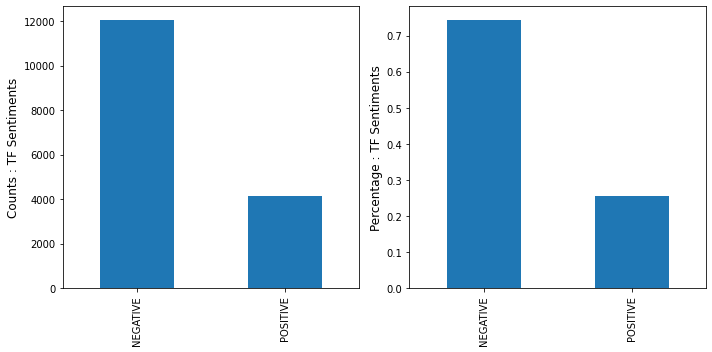

In [32]:
print("Distribution of classes : Transformer")
counts = df['tf-sentiment'].value_counts()
percent = counts/sum(counts)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

counts.plot(kind='bar', ax=ax1)
percent.plot(kind='bar', ax=ax2)
ax1.set_ylabel('Counts : TF Sentiments', size=12)
ax2.set_ylabel('Percentage : TF Sentiments', size=12)
plt.tight_layout()
plt.show()

Transformer is clasifying most of the tweets as negative. Let's see about VADER.

Distribution of classes : Vader


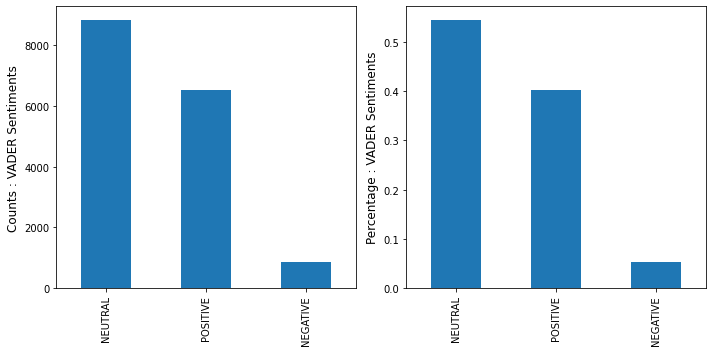

In [33]:
print("Distribution of classes : Vader")
counts = df['vader-sentiment'].value_counts()
percent = counts/sum(counts)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

counts.plot(kind='bar', ax=ax1)
percent.plot(kind='bar', ax=ax2)
ax1.set_ylabel('Counts : VADER Sentiments', size=12)
ax2.set_ylabel('Percentage : VADER Sentiments', size=12)
plt.tight_layout()
plt.show()

Let's see side by side.

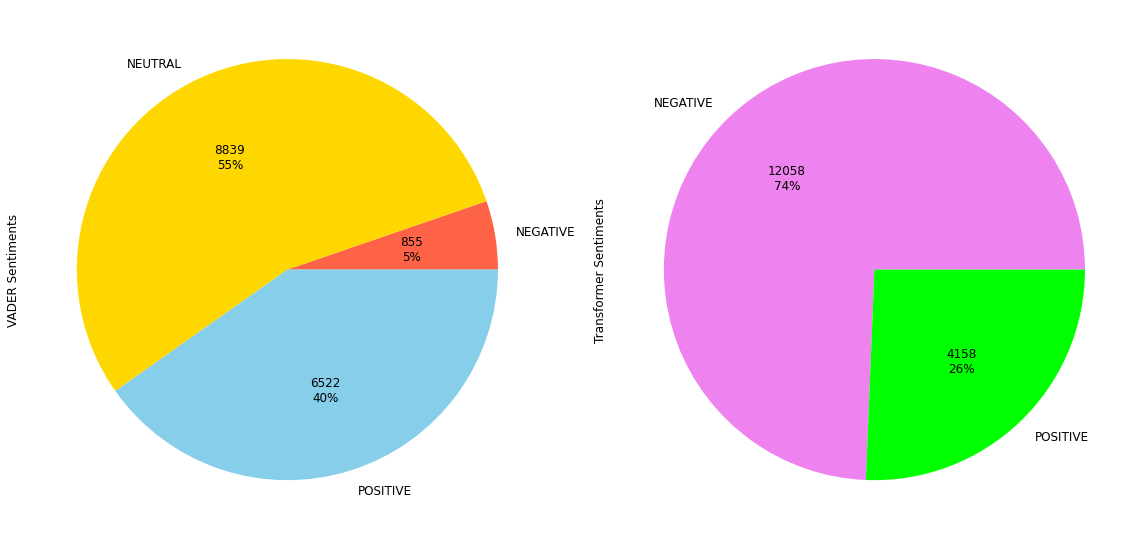

In [34]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

df.groupby('vader-sentiment').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 12},
                                  colors=['tomato', 'gold', 'skyblue'], ax=ax1)
df.groupby('tf-sentiment').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 12},
                                 colors=['violet', 'lime'], ax=ax2)
ax1.set_ylabel('VADER Sentiments', size=12)
ax2.set_ylabel('Transformer Sentiments', size=12)
plt.tight_layout()
plt.show()

Clearly there is a lot of difference! Let's dig down further!

In [35]:
def same_or_diff(x):
    if x[0]==x[1]:
        return "Same"
    else:
        return "Different"

In [36]:
print("Same or Different including the Neutral records")
df['same_or_diff_w_neut'] = df[['tf-sentiment', 'vader-sentiment']].apply(same_or_diff, axis=1)
df.head(3)

Same or Different including the Neutral records


,Text,tf-score,tf-sentiment,vader-sentiment,same_or_diff_w_neut
16405,Bella Protocol BEL 4x Long ( 14% profit booke...,0.9966,NEGATIVE,POSITIVE,Different
16403,"""Data further suggests that crypto ATMs are be...",0.9954,NEGATIVE,NEUTRAL,Different
16402,RT : Join us for a zoom get together on BCHday...,0.9969,POSITIVE,POSITIVE,Same


Same or Different including the Neutral records : Comparision


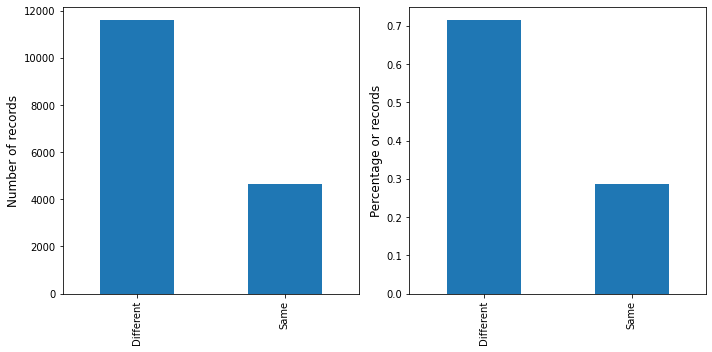

In [37]:
print("Same or Different including the Neutral records : Comparision")
counts = df['same_or_diff_w_neut'].value_counts()
percent = counts/sum(counts)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

counts.plot(kind='bar', ax=ax1)
percent.plot(kind='bar', ax=ax2)
ax1.set_ylabel('Number of records', size=12)
ax2.set_ylabel('Percentage or records', size=12)
plt.tight_layout()
plt.show()

In [38]:
print("Same or Different after removing the Neutral records")
dfwn = df[df['vader-sentiment'] != 'NEUTRAL']
# Just to ensure
print("==================================\n")
print(dfwn['vader-sentiment'].value_counts())
dfwn['same_or_diff_wo_neut'] = dfwn[['tf-sentiment', 'vader-sentiment']].apply(same_or_diff, axis=1)
dfwn.head(3)

Same or Different after removing the Neutral records

POSITIVE    6522
NEGATIVE     855
Name: vader-sentiment, dtype: int64


,Text,tf-score,tf-sentiment,vader-sentiment,same_or_diff_w_neut,same_or_diff_wo_neut
16405,Bella Protocol BEL 4x Long ( 14% profit booke...,0.9966,NEGATIVE,POSITIVE,Different,Different
16402,RT : Join us for a zoom get together on BCHday...,0.9969,POSITIVE,POSITIVE,Same,Same
16401,DODO 4x Long ( 38% profit booked ) 31 July 202...,0.9980,NEGATIVE,POSITIVE,Different,Different


Same or Different after removing the Neutral records : Comparision


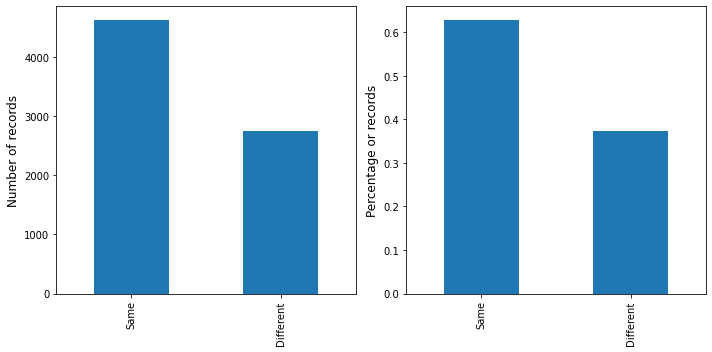

In [39]:
print("Same or Different after removing the Neutral records : Comparision")
counts = dfwn['same_or_diff_wo_neut'].value_counts()
percent = counts/sum(counts)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))

counts.plot(kind='bar', ax=ax1)
percent.plot(kind='bar', ax=ax2)
ax1.set_ylabel('Number of records', size=12)
ax2.set_ylabel('Percentage or records', size=12)
plt.tight_layout()
plt.show()

Let's see at some records !!

In [41]:
df['color'] = df['same_or_diff_w_neut'].apply(lambda x : "green" if x == 'Same' else 'red')

fig = go.Figure(data=[go.Table(
    columnorder = [1,2,3,4],
    columnwidth = [400, 100, 100, 120],
    header=dict(values=['Text', 'tf-sentiment', 'vader-sentiment', 'same_or_different'],
                fill_color='paleturquoise',
                line_color='black',
                align='center',
                height=40),
    cells=dict(values=[df['Text'],df['tf-sentiment'], df['vader-sentiment'], df['same_or_diff_w_neut']],
               fill_color=[['lavender'], ['lavender'], ['lavender'], list(df.color)],
               line_color='black',
               align='left'))
])

fig.update_layout(height=700,
                 title="Comparision across Transformer and VADER")

fig.show()

# We can clearly see the differences!